In [1]:
%reload_ext autoreload
%autoreload 2

1. download all parts of helen data - combine all into train folder (should hve 2330)
2. rename annotation files with image (1.txt -> 100032540_1_anno.txt)

In [2]:
from fastai.vision import *
from fastai.datasets import *

### Download Helen Facepoint Data

In [3]:
path = Path('/home/sudosharma/projects/data/helen/')

### Rename annotation files

In [31]:
def rename_anno_files(anno_path):
    for anno in anno_path.ls():
        if anno.stem.find('anno') > 0: 
            return
        with open(anno) as f:
            fname = f.readline().strip()
        anno.rename(anno.parent / f'{fname}_anno.txt')
    return

In [32]:
rename_anno_files(path/'annotation')

### Prep Dataloader

In [4]:
def _get_size(xs,i):
    size = xs.sizes.get(i,None)
    if size is None:
        # Image hasn't been accessed yet, so we don't know its size
        _ = xs[i]
        size = xs.sizes[i]
    return size

class CustomPointsProcessor(PreProcessor):
    "`PreProcessor` that stores the number of targets for point regression."
    def __init__(self, ds:ItemList): self.c = 136
    def process(self, ds:ItemList):  ds.c = self.c

class CustomPointsLabelList(ItemList):
    "`ItemList` for points."
    _processor = CustomPointsProcessor

    def __post_init__(self): self.loss_func = MSELossFlat()

    def get(self, i):
        o = super().get(i)
        return ImagePoints(FlowField(_get_size(self.x,i), o), scale=True)

    def analyze_pred(self, pred, thresh:float=0.5): return pred.view(-1,2)
    def reconstruct(self, t, x): return ImagePoints(FlowField(x.size, t), scale=False)
    
def data_collate(batch:ItemsList)->Tensor:
    "Convert `batch` items to tensor data."
    return torch.utils.data.dataloader.default_collate(to_data(batch))

In [5]:
def get_annos(o):
    anno = path/'annotation'/f'{o.stem}_anno.txt'
    points = []
    with open(anno) as f:
        for line in f:
            points.append([float(coord) for coord in line.strip().split(',')][::-1])
    points = torch.Tensor(points[59:])
    return points

def get_data(sz=512, bs=1, path=path):
    return (PointsItemList.from_folder(path)
            .split_by_rand_pct(0.1)
            .label_from_func(get_annos, label_cls=CustomPointsLabelList)
            .transform(get_transforms(), tfm_y=True, size=sz)
            .databunch(bs=bs))

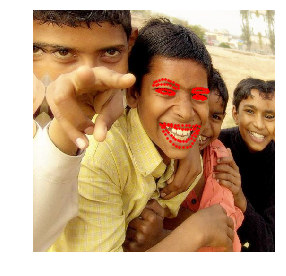

In [6]:
data = get_data()
data.show_batch()

### Train Model

In [7]:
class Print(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x
    
@dataclass
class PadTarget(LearnerCallback):
    learn: Learner
    def on_batch_begin(self, **kwargs):
        target = kwargs['last_target']
        if target.shape[1] < 136:
            target = F.pad(target, (0, 0, 136-target.shape[1], 0))
        return {'last_target': target}

In [8]:
def anon_block():
    pass

class AnonNet(nn.Module):
    def __init__(self, backbone, pretrained=True):
        super().__init__()
        self.base = create_body(backbone, pretrained=pretrained)
        self.layers = nn.Sequential(
            AdaptiveConcatPool2d(1), 
            Flatten(), 
            nn.Linear(1024, 272), 
            nn.ReLU(True))
    
    def forward(self, x):
        return self.layers(self.base(x)).view(136, -1)

In [9]:
backbone = models.resnet34
model = AnonNet(backbone)
learn = Learner(data, model, opt_func=AdamW, loss_func=F.mse_loss, callback_fns=[PadTarget])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


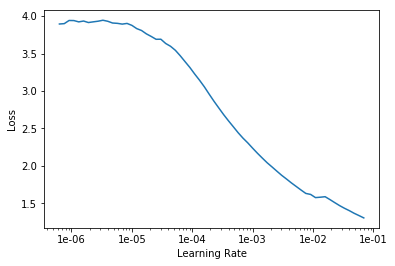

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit(50, 1e-1)

epoch,train_loss,valid_loss,time
0,0.104819,0.086714,01:01


KeyboardInterrupt: 

In [12]:
learn.plot.losses()

AttributeError: 'Learner' object has no attribute 'plot'

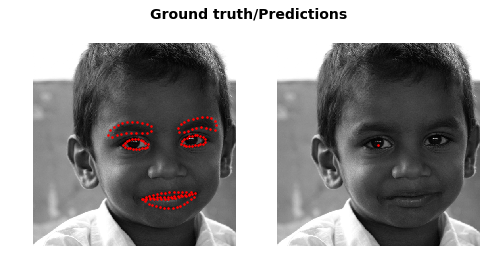

In [13]:
learn.show_results()